In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '25 days LSTM Time Series Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## noncyclic Stocks

### Kweichow Moutai Co.,Ltd.

In [8]:
nr_test_sets = ['600519.SS']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
 
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2018-12-06   610.099976  577.824500  -9.014119  1.233718e+09     2.0
2018-12-07   591.799988  579.974575 -34.788750  1.229942e+09     2.0
2018-12-10   587.000000  581.055409 -41.549296  1.227258e+09     2.0
2018-12-11   577.229980  580.466882 -55.309887  1.224794e+09     2.0
2018-12-12   582.989990  580.855052 -47.197197  1.226426e+09     2.0


In [9]:
r_test_sets = ['600519.SS']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2019-12-09  1170.000000  1159.718126 -55.632382  56851872.0     2.0
2019-12-10  1158.699951  1159.561484 -63.820930  54669460.0     2.0
2019-12-11  1164.400024  1160.305875 -57.992161  56178118.0     2.0
2019-12-12  1158.979980  1160.101891 -60.304908  54721319.0     2.0
2019-12-13  1137.000000  1156.547754 -71.870264  51780403.0     2.0


### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


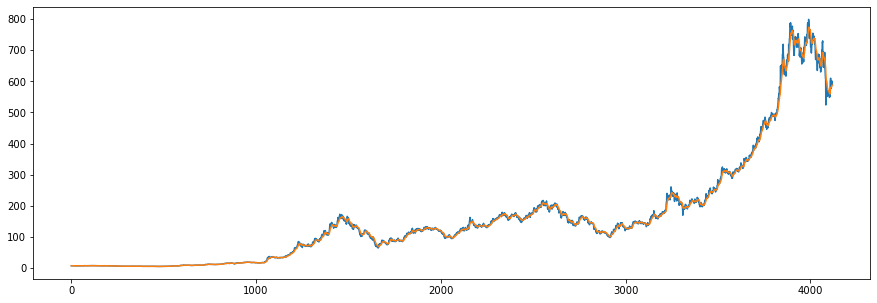

In [10]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/600519.SS_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 25, 4)
y = labels
y = np.array(y)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 3730, 1.0: 182, 0.0: 184})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('600519.SS')]
    y = nr_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('600519.SS'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('600519.SS')]
    y = r_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('600519.SS'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.428571428571429, 1: 7.47945205479452, 2: 0.36607442172309757}



RUNNING EPOCHS 0 - 20



Epoch 1/20
26/26 [==============================] - 1s 38ms/step - loss: 0.2910 - accuracy: 0.5675 - mse: 0.4313 - weighted_accuracy: 0.3420 - weighted_mse: 0.5213 - val_loss: 0.3009 - val_accuracy: 0.0427 - val_mse: 0.3521 - val_weighted_accuracy: 0.0427 - val_weighted_mse: 0.3521
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.2181 - accuracy: 0.4386 - mse: 0.7218 - weighted_accuracy: 0.3987 - weighted_mse: 0.7417 - val_loss: 0.2930 - val_accuracy: 0.0439 - val_mse: 0.3752 - val_weighted_accuracy: 0.0439 - val_weighted_mse: 0.3752
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1965 - accuracy: 0.4231 - mse: 0.9226 - weighted_accuracy: 0.4795 - weighted_mse: 0.9319 - val_loss: 0.2851 - val_accuracy: 0.0439 - val_mse: 0.4085 - val_weighted_accuracy: 0.0439 - val_weighted_mse: 0.4085
Epoch 4/20
26/26 [==============================] - 0s 9m

7/7 [==============================] - 0s 3ms/step - loss: 0.1842 - accuracy: 0.3413 - mse: 1.1640 - weighted_accuracy: 0.3413 - weighted_mse: 1.1640


<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.18424519896507263
Test accuracy: 0.3413461446762085


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 4
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 56
actual holds but predicted sell: 69
actual predicted holds: 64
Percentage buys correct: 6.25%
Percentage sells correct: 4.109589041095891%
Percentage holds correct: 90.14084507042253%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 39.0625%
Percentage high sells correct: 41.0958904109589%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 15.717304419064138%
Share price: $0.14572012793439182
Shares owned at the moment: 0
Cash capital at the moment: $115.39701612988347


Share price: $0.10

26/26 [==============================] - 0s 8ms/step - loss: 0.1348 - accuracy: 0.4435 - mse: 1.5959 - weighted_accuracy: 0.7293 - weighted_mse: 1.5482 - val_loss: 0.1876 - val_accuracy: 0.3988 - val_mse: 1.5854 - val_weighted_accuracy: 0.3988 - val_weighted_mse: 1.5854
Epoch 15/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1345 - accuracy: 0.5064 - mse: 1.5637 - weighted_accuracy: 0.7393 - weighted_mse: 1.5219 - val_loss: 0.2041 - val_accuracy: 0.3512 - val_mse: 1.6607 - val_weighted_accuracy: 0.3512 - val_weighted_mse: 1.6607
Epoch 16/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1341 - accuracy: 0.4429 - mse: 1.6166 - weighted_accuracy: 0.7161 - weighted_mse: 1.5649 - val_loss: 0.2009 - val_accuracy: 0.3646 - val_mse: 1.7429 - val_weighted_accuracy: 0.3646 - val_weighted_mse: 1.7429
Epoch 17/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1328 - accuracy: 0.4759 - mse: 1.6206 - weighted_accuracy: 0.7304 - weighted_mse: 1.5760

<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 40 - 60



Epoch 1/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1255 - accuracy: 0.4933 - mse: 1.6775 - weighted_accuracy: 0.7562 - weighted_mse: 1.6355 - val_loss: 0.1915 - val_accuracy: 0.4256 - val_mse: 1.7874 - val_weighted_accuracy: 0.4256 - val_weighted_mse: 1.7874
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1254 - accuracy: 0.5098 - mse: 1.6898 - weighted_accuracy: 0.7687 - weighted_mse: 1.6482 - val_loss: 0.1928 - val_accuracy: 0.3988 - val_mse: 1.8690 - val_weighted_accuracy: 0.3988 - val_weighted_mse: 1.8690
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1252 - accuracy: 0.5143 - mse: 1.7138 - weighted_accuracy: 0.7574 - weighted_mse: 1.6832 - val_loss: 0.1989 - val_accuracy: 0.3927 - val_mse: 1.8241 - val_weighted_accuracy: 0.3927 - val_weighted_mse: 1.8241
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1243 - accuracy: 0.5229 - mse: 1.7386 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.1844 - accuracy: 0.4327 - mse: 2.2815 - weighted_accuracy: 0.4327 - weighted_mse: 2.2815
Test loss: 0.18440791964530945
Test accuracy: 0.4326923191547394


number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 3
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 23
actual holds but predicted sell: 83
actual predicted holds: 83
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 5.4945054945054945%
Percentage holds correct: 91.20879120879121%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 57.69230769230769%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase 

<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1070 - accuracy: 0.6068 - mse: 2.0200 - weighted_accuracy: 0.8388 - weighted_mse: 2.0298 - val_loss: 0.1811 - val_accuracy: 0.5061 - val_mse: 2.1299 - val_weighted_accuracy: 0.5061 - val_weighted_mse: 2.1299
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1073 - accuracy: 0.5934 - mse: 2.0409 - weighted_accuracy: 0.8252 - weighted_mse: 2.0447 - val_loss: 0.1812 - val_accuracy: 0.5037 - val_mse: 2.2263 - val_weighted_accuracy: 0.5037 - val_weighted_mse: 2.2263
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1070 - accuracy: 0.6224 - mse: 2.0536 - weighted_accuracy: 0.8229 - weighted_mse: 2.0603 - val_loss: 0.2036 - val_accuracy: 0.4561 - val_mse: 2.2591 - val_weighted_accuracy: 0.4561 - val_weighted_mse: 2.2591
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1065 - accuracy: 0.6166 - mse: 2.0896 - weighted_accuracy: 0.8251 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1826 - accuracy: 0.5000 - mse: 2.8333 - weighted_accuracy: 0.5000 - weighted_mse: 2.8333
Test loss: 0.18263006210327148
Test accuracy: 0.5


number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 3
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 27
actual holds but predicted sell: 65
actual predicted holds: 97
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 6.8493150684931505%
Percentage holds correct: 92.38095238095238%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 52.054794520547944%
Percentage mid holds correct: 86.53846153846153%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase f

<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0901 - accuracy: 0.6920 - mse: 2.4748 - weighted_accuracy: 0.8743 - weighted_mse: 2.5368 - val_loss: 0.1787 - val_accuracy: 0.5439 - val_mse: 2.6810 - val_weighted_accuracy: 0.5439 - val_weighted_mse: 2.6810
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0914 - accuracy: 0.6774 - mse: 2.4999 - weighted_accuracy: 0.8689 - weighted_mse: 2.5444 - val_loss: 0.1785 - val_accuracy: 0.5890 - val_mse: 2.7357 - val_weighted_accuracy: 0.5890 - val_weighted_mse: 2.7357
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0903 - accuracy: 0.7070 - mse: 2.5298 - weighted_accuracy: 0.8711 - weighted_mse: 2.5804 - val_loss: 0.1903 - val_accuracy: 0.5671 - val_mse: 2.7618 - val_weighted_accuracy: 0.5671 - val_weighted_mse: 2.7618
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0903 - accuracy: 0.6966 - mse: 2.5640 - weighted_accuracy: 0.8716 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1699 - accuracy: 0.5962 - mse: 3.5241 - weighted_accuracy: 0.5962 - weighted_mse: 3.5241
Test loss: 0.169895201921463
Test accuracy: 0.5961538553237915


number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 3
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 28
actual holds but predicted sell: 42
actual predicted holds: 119
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 6.25%
Percentage holds correct: 92.24806201550388%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 51.61290322580645%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 86.71875%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previo

<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0751 - accuracy: 0.7552 - mse: 3.0967 - weighted_accuracy: 0.9017 - weighted_mse: 3.1799 - val_loss: 0.1834 - val_accuracy: 0.6037 - val_mse: 3.3231 - val_weighted_accuracy: 0.6037 - val_weighted_mse: 3.3231
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0767 - accuracy: 0.7479 - mse: 3.1314 - weighted_accuracy: 0.8991 - weighted_mse: 3.1810 - val_loss: 0.1763 - val_accuracy: 0.6280 - val_mse: 3.4898 - val_weighted_accuracy: 0.6280 - val_weighted_mse: 3.4898
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0760 - accuracy: 0.7564 - mse: 3.1790 - weighted_accuracy: 0.8978 - weighted_mse: 3.2263 - val_loss: 0.1954 - val_accuracy: 0.6098 - val_mse: 3.3491 - val_weighted_accuracy: 0.6098 - val_weighted_mse: 3.3491
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0759 - accuracy: 0.7540 - mse: 3.2090 - weighted_accuracy: 0.9078 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1652 - accuracy: 0.6731 - mse: 4.5295 - weighted_accuracy: 0.6731 - weighted_mse: 4.5295
Test loss: 0.16517703235149384
Test accuracy: 0.6730769276618958


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 3
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 23
actual holds but predicted sell: 28
actual predicted holds: 138
Percentage buys correct: 4.0%
Percentage sells correct: 3.125%
Percentage holds correct: 91.3907284768212%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 52.0%
Percentage high sells correct: 46.875%
Percentage mid holds correct: 85.33333333333333%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 14.685293009575

<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0629 - accuracy: 0.8031 - mse: 3.8987 - weighted_accuracy: 0.9258 - weighted_mse: 3.9437 - val_loss: 0.1854 - val_accuracy: 0.6573 - val_mse: 4.1396 - val_weighted_accuracy: 0.6573 - val_weighted_mse: 4.1396
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0644 - accuracy: 0.8001 - mse: 3.9482 - weighted_accuracy: 0.9247 - weighted_mse: 3.9509 - val_loss: 0.1757 - val_accuracy: 0.6939 - val_mse: 4.4543 - val_weighted_accuracy: 0.6939 - val_weighted_mse: 4.4543
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0637 - accuracy: 0.7967 - mse: 3.9950 - weighted_accuracy: 0.9147 - weighted_mse: 3.9843 - val_loss: 0.1927 - val_accuracy: 0.6549 - val_mse: 4.2199 - val_weighted_accuracy: 0.6549 - val_weighted_mse: 4.2199
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0638 - accuracy: 0.8037 - mse: 4.0385 - weighted_accuracy: 0.9260 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1740 - accuracy: 0.7163 - mse: 5.7541 - weighted_accuracy: 0.7163 - weighted_mse: 5.7541
Test loss: 0.17395104467868805
Test accuracy: 0.7163461446762085


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2

<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


actual sells but predicted hold: 7
actual holds but predicted buy: 23
actual holds but predicted sell: 20
actual predicted holds: 146
Percentage buys correct: 4.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 91.82389937106919%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 48.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.44303797468355%


Capital: 100
Share price: $0.1503089080399258
Shares owned at the moment: 663
Cash capital at the moment: $0.07114325294539015


Price increase from previously bought: -4.18101336199852%
Share price: $0.14442053980990632
Shares owned at the moment: 0
Cash capital at the moment: $95.55864639770486


Share price: $0.10063732183484929
Shares owned at the moment: 946
Cash capital at the moment: $0.09393194918406778


Price increase from previously bought: 91.68450702548779%
Share price: $0.1934366461669521
Shares owned at the moment: 0
Cash capital at the moment: $182

Epoch 18/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0467 - accuracy: 0.8614 - mse: 5.8406 - weighted_accuracy: 0.9449 - weighted_mse: 5.5409 - val_loss: 0.2034 - val_accuracy: 0.7073 - val_mse: 6.1382 - val_weighted_accuracy: 0.7073 - val_weighted_mse: 6.1382
Epoch 19/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0453 - accuracy: 0.8703 - mse: 5.8730 - weighted_accuracy: 0.9482 - weighted_mse: 5.5672 - val_loss: 0.1928 - val_accuracy: 0.7585 - val_mse: 6.7211 - val_weighted_accuracy: 0.7585 - val_weighted_mse: 6.7211
Epoch 20/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0451 - accuracy: 0.8703 - mse: 5.9376 - weighted_accuracy: 0.9525 - weighted_mse: 5.5980 - val_loss: 0.1902 - val_accuracy: 0.7463 - val_mse: 6.2028 - val_weighted_accuracy: 0.7463 - val_weighted_mse: 6.2028
Validation loss: 0.190225288271904
Validation accuracy: 0.7463414669036865


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - 

<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 9ms/step - loss: 0.0456 - accuracy: 0.8623 - mse: 5.9782 - weighted_accuracy: 0.9474 - weighted_mse: 5.7440 - val_loss: 0.2058 - val_accuracy: 0.7183 - val_mse: 6.0826 - val_weighted_accuracy: 0.7183 - val_weighted_mse: 6.0826
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0465 - accuracy: 0.8660 - mse: 6.0105 - weighted_accuracy: 0.9509 - weighted_mse: 5.6968 - val_loss: 0.1929 - val_accuracy: 0.7744 - val_mse: 7.1766 - val_weighted_accuracy: 0.7744 - val_weighted_mse: 7.1766
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0445 - accuracy: 0.8752 - mse: 6.1158 - weighted_accuracy: 0.9521 - weighted_mse: 5.7693 - val_loss: 0.2135 - val_accuracy: 0.7207 - val_mse: 6.3341 - val_weighted_accuracy: 0.7207 - val_weighted_mse: 6.3341
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0451 - accuracy: 0.8767 - mse: 6.1816 - weighted_accuracy: 0.9527 - weighted_mse: 5.7734 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1968 - accuracy: 0.7644 - mse: 9.0998 - weighted_accuracy: 0.7644 - weighted_mse: 9.0998
Test loss: 0.196756973862648
Test accuracy: 0.7644230723381042


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 16
actual holds but predicted sell: 15
actual predicted holds: 158
Percentage buys correct: 0.0%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 90.28571428571429%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 43.75%
Percentage high sells correct: 52.94117647058823%
Percentage mid holds correct: 83.9080459770115%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase from previously bo

<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 10ms/step - loss: 0.0388 - accuracy: 0.8895 - mse: 7.2339 - weighted_accuracy: 0.9595 - weighted_mse: 6.7153 - val_loss: 0.2214 - val_accuracy: 0.7366 - val_mse: 7.5848 - val_weighted_accuracy: 0.7366 - val_weighted_mse: 7.5848
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0396 - accuracy: 0.8901 - mse: 7.2925 - weighted_accuracy: 0.9598 - weighted_mse: 6.7012 - val_loss: 0.2166 - val_accuracy: 0.7829 - val_mse: 8.9036 - val_weighted_accuracy: 0.7829 - val_weighted_mse: 8.9036
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0380 - accuracy: 0.8984 - mse: 7.4225 - weighted_accuracy: 0.9584 - weighted_mse: 6.7936 - val_loss: 0.2277 - val_accuracy: 0.7439 - val_mse: 7.7653 - val_weighted_accuracy: 0.7439 - val_weighted_mse: 7.7653
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0383 - accuracy: 0.9005 - mse: 7.4860 - weighted_accuracy: 0.9636 - weighted_mse: 6.7967 -

7/7 [==============================] - 0s 3ms/step - loss: 0.2269 - accuracy: 0.7885 - mse: 10.5076 - weighted_accuracy: 0.7885 - weighted_mse: 10.5076
Test loss: 0.22691133618354797
Test accuracy: 0.7884615659713745


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 3
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 12
actual holds but predicted sell: 15
actual predicted holds: 162
Percentage buys correct: 0.0%
Percentage sells correct: 10.0%
Percentage holds correct: 92.04545454545455%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase from previously bought: 91.6845070254877

<ipython-input-16-ae36bc18f37d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-ae36bc18f37d>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-ae36bc18f37d>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [17]:
df = nr_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.328502,7.246377,7.142857,85.294118,46.376812,43.478261,82.352941,380.320411,1666.892281
1,0.449275,12.244898,11.267606,90.804598,55.102041,50.000000,85.057471,239.344873,1666.892281
2,0.541063,10.638298,10.638298,90.265487,46.808511,52.173913,85.840708,246.112815,1666.892281
3,0.545894,8.695652,11.111111,89.655172,43.478261,50.000000,85.344828,191.429248,1666.892281
4,0.632850,10.256410,12.903226,89.781022,43.589744,63.333333,86.131387,463.521758,1666.892281
5,0.690821,11.111111,11.111111,89.542484,52.777778,52.941176,84.967320,304.461306,1666.892281
6,0.729469,14.814815,5.882353,89.570552,55.555556,43.750000,85.276074,142.243902,1666.892281
7,0.743961,12.000000,7.142857,89.285714,52.000000,53.846154,85.119048,1486.021415,1666.892281
8,0.768116,15.000000,7.142857,89.595376,55.000000,61.538462,85.549133,1526.122027,1666.892281
9,0.792271,16.666667,9.090909,89.887640,61.111111,50.000000,85.955056,1424.547772,1666.892281


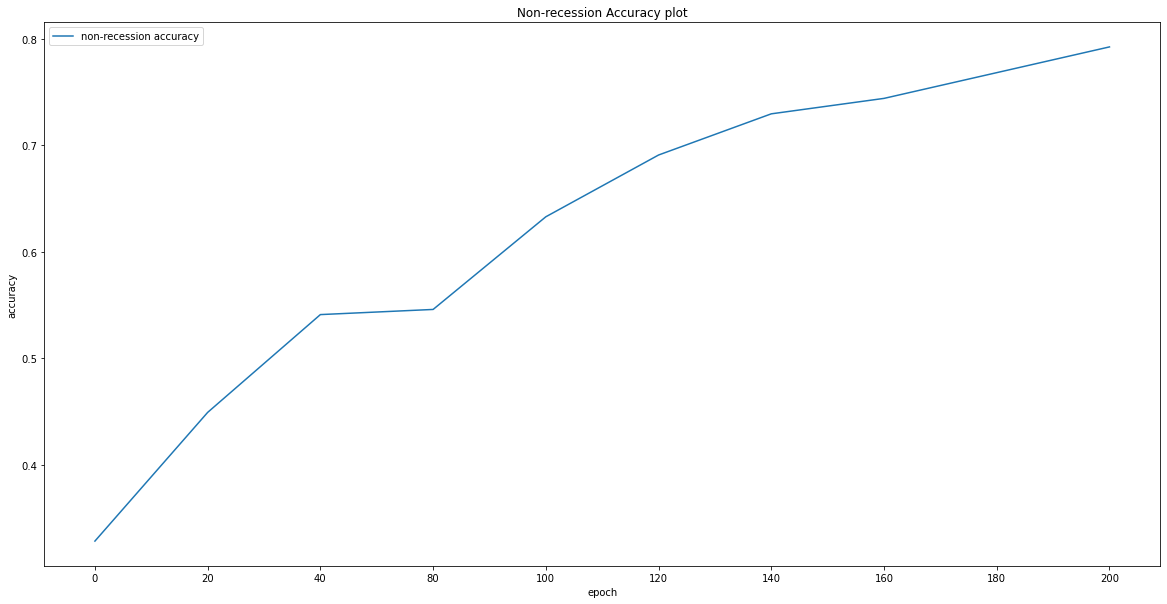

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

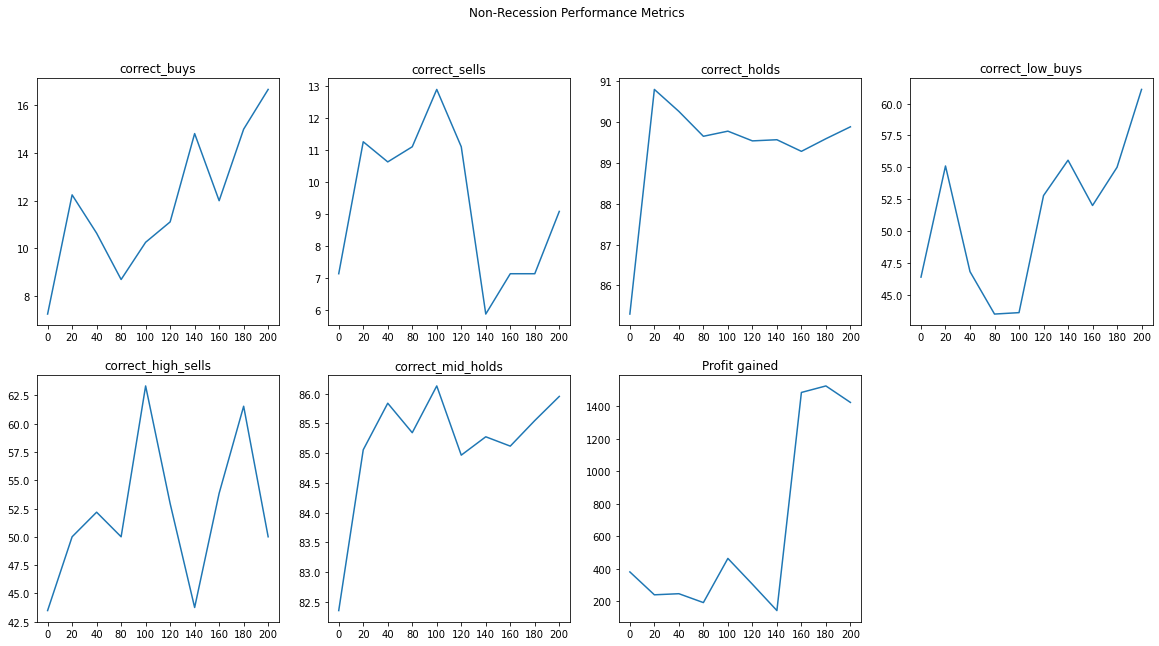

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

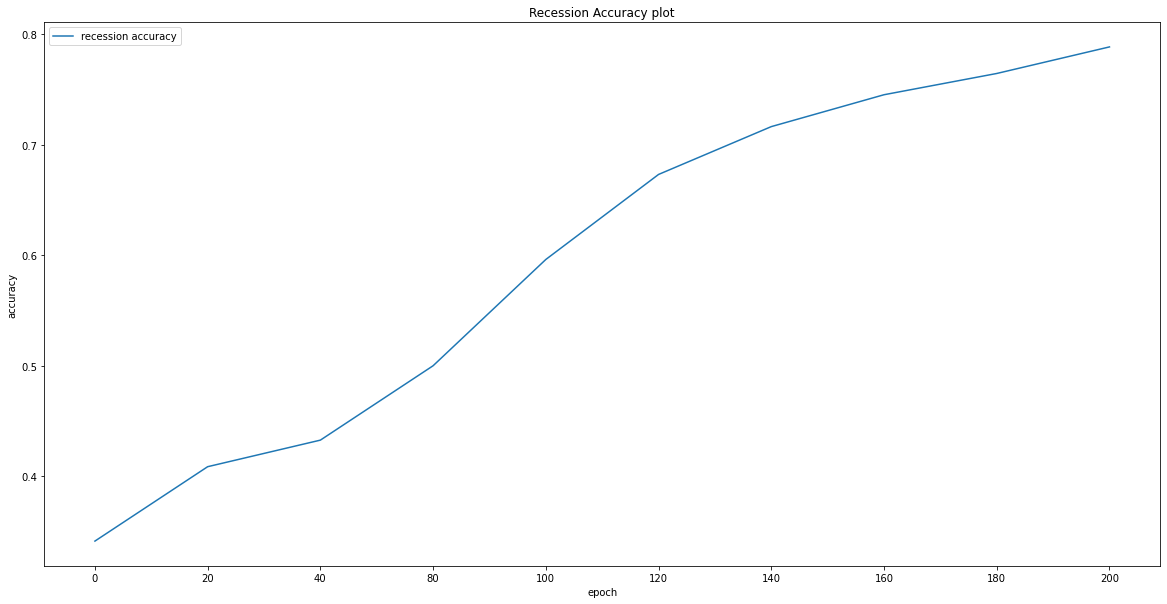

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

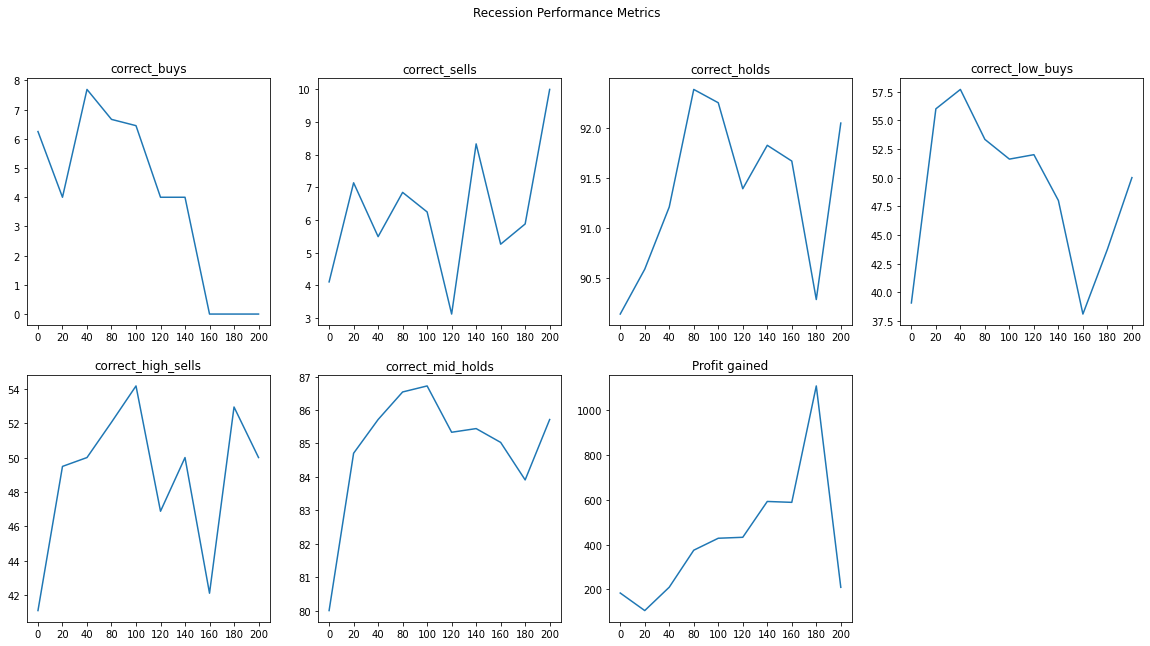

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Midea

In [22]:
nr_test_sets = ['000333.SZ']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-12-06    40.000000  40.092585 -59.624405  5.053315e+09     2.0
2018-12-07    38.959999  39.918341 -83.886253  5.032045e+09     2.0
2018-12-10    38.480000  39.697058 -94.264348  5.009379e+09     2.0
2018-12-11    37.060001  39.291357 -91.990799  4.974723e+09     1.0
2018-12-12    37.040001  38.944994 -87.280665  4.947635e+09     2.0


In [23]:
r_test_sets = ['000333.SZ']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
    

    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2019-12-09    56.200001  55.641030 -41.801348  1.203534e+09     2.0
2019-12-10    56.810001  55.820872 -27.713568  1.224386e+09     2.0
2019-12-11    57.650002  56.102276  -5.476179  1.245103e+09     2.0
2019-12-12    57.060001  56.249619 -19.523799  1.231138e+09     2.0
2019-12-13    56.919998  56.352754 -22.857208  1.218430e+09     2.0


### training Data

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


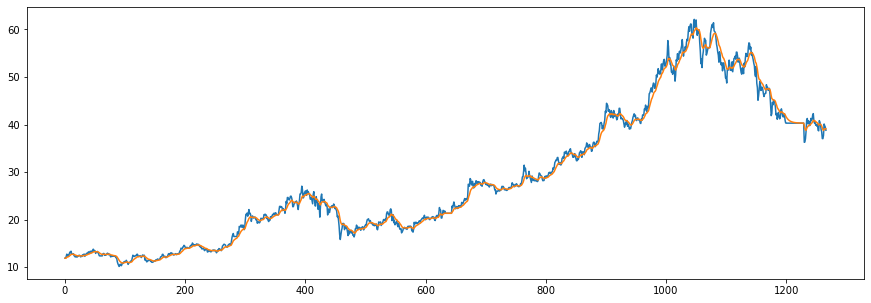

In [24]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1   
    
X  = np.array(sequential).reshape(-1, 25, 4)
y = labels
y = np.array(y)

In [25]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [26]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('000333.SZ')]
    y = nr_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('000333.SZ'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('000333.SZ')]
    y = r_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('000333.SZ'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 0 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 0 2 2 2 2 2 2 2 2 2 2 0 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 0 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 0 0 1 2 2 2 2 2 2 0 2 2
 1 1 2 1 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 

{0: 8.08130081300813, 1: 6.761904761904762, 2: 0.3665191740412979}



RUNNING EPOCHS 0 - 20



Epoch 1/20
8/8 [==============================] - 1s 94ms/step - loss: 0.3364 - accuracy: 0.6056 - mse: 0.3351 - weighted_accuracy: 0.3018 - weighted_mse: 0.4498 - val_loss: 0.3028 - val_accuracy: 0.0803 - val_mse: 0.3379 - val_weighted_accuracy: 0.0803 - val_weighted_mse: 0.3379
Epoch 2/20
8/8 [==============================] - 0s 10ms/step - loss: 0.2789 - accuracy: 0.5785 - mse: 0.4057 - weighted_accuracy: 0.3873 - weighted_mse: 0.4832 - val_loss: 0.3028 - val_accuracy: 0.0683 - val_mse: 0.3449 - val_weighted_accuracy: 0.0683 - val_weighted_mse: 0.3449
Epoch 3/20
8/8 [==============================] - 0s 11ms/step - loss: 0.2455 - accuracy: 0.5493 - mse: 0.4886 - weighted_accuracy: 0.4502 - weighted_mse: 0.5399 - val_loss: 0.3005 - val_accuracy: 0.0602 - val_mse: 0.3503 - val_weighted_accuracy: 0.0602 - val_weighted_mse: 0.3503
Epoch 4/20
8/8 [==============================] - 0s 9ms/step 

<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.24732249975204468
Test accuracy: 0.03365384787321091


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 8
actual predicted sells: 0
actual sells but predicted hold: 0
actual holds but predicted buy: 193
actual holds but predicted sell: 0
actual predicted holds: 0
Percentage buys correct: 3.3653846153846154%
Percentage sells correct: 0%
Percentage holds correct: 0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 42.028985507246375%
Percentage high sells correct: 0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075




Capital at the end of test period: $568.5733088396158
profit gained: 468.5733088396159%


Capital at the end of test period if Buy and Hold: $568.5733088396158
profit gained: 468.5733088396159%
   Test_accuracy  cor

7/7 [==============================] - 0s 3ms/step - loss: 0.2028 - accuracy: 0.4183 - mse: 0.8412 - weighted_accuracy: 0.4183 - weighted_mse: 0.8412
Test loss: 0.20278245210647583
Test accuracy: 0.41826921701431274




<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 4
actual predicted sells: 0
actual sells but predicted hold: 4
actual holds but predicted buy: 94
actual holds but predicted sell: 14
actual predicted holds: 85
Percentage buys correct: 2.0%
Percentage sells correct: 0.0%
Percentage holds correct: 90.42553191489361%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 39.39393939393939%
Percentage high sells correct: 35.714285714285715%
Percentage mid holds correct: 84.04255319148936%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously bought: 72.57279979268141%
Share price: $0.2725368589303062
Shares owned at the moment: 0
Cash capital at the moment: $172.07442421371428


Share price: $0.26136958565763846
Shares owned at the moment: 656
Cash capital

8/8 [==============================] - 0s 8ms/step - loss: 0.1094 - accuracy: 0.6046 - mse: 1.5013 - weighted_accuracy: 0.8487 - weighted_mse: 1.4854 - val_loss: 0.1568 - val_accuracy: 0.6104 - val_mse: 1.1358 - val_weighted_accuracy: 0.6104 - val_weighted_mse: 1.1358
Validation loss: 0.1567942202091217
Validation accuracy: 0.6104417443275452


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1624 - accuracy: 0.5942 - mse: 1.1418 - weighted_accuracy: 0.5942 - weighted_mse: 1.1418
Test loss: 0.16236840188503265
Test accuracy: 0.5942028760910034


number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 3
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 19
actual holds but predicted sell: 50
actual predicted holds: 117
Percentage buys correct: 5.0%
Percentage sells correct: 8.620689655172415%
Percentage holds correct: 

<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 20
actual holds but predicted sell: 48
actual predicted holds: 125
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 2.0408163265306123%
Percentage holds correct: 91.91176470588235%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 45.833333333333336%
Percentage mid holds correct: 85.29411764705883%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously bought: -61.38041033966471%
Share price: $0.06099027003009471
Shares owned at the moment: 0
Cash capital at the moment: $38.533683164508425


Share price: $0.22660343399922545
Shares owned

Cash capital at the moment: $0.24352474940315005


Price increase from previously bought: -26.499885789008204%
Share price: $0.4766197894061859
Shares owned at the moment: 0
Cash capital at the moment: $1459.9177247393172


Share price: $0.6066267137655352
Shares owned at the moment: 2400
Cash capital at the moment: $0.009875391180003135


Price increase from previously bought: 57.95102635120786%
Share price: $0.9608080965946784
Shares owned at the moment: 0
Cash capital at the moment: $2299.607973780883


Share price: $0.8209628451691258
Shares owned at the moment: 2793
Cash capital at the moment: $0.3531368504823149


Price increase from previously bought: -1.0425305275880148%
Share price: $0.8146381680445247
Shares owned at the moment: 0
Cash capital at the moment: $2269.380508089632




Capital at the end of test period: $2269.380508089632
profit gained: 2169.380508089632%


Capital at the end of test period if Buy and Hold: $1345.2754815401652
profit gained: 1245.2754815401652%
  

<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 80 - 100



Epoch 1/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0912 - accuracy: 0.7062 - mse: 1.7289 - weighted_accuracy: 0.8923 - weighted_mse: 1.7685 - val_loss: 0.1496 - val_accuracy: 0.6466 - val_mse: 1.5841 - val_weighted_accuracy: 0.6466 - val_weighted_mse: 1.5841
Epoch 2/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0896 - accuracy: 0.7082 - mse: 1.7508 - weighted_accuracy: 0.8931 - weighted_mse: 1.7854 - val_loss: 0.1474 - val_accuracy: 0.6627 - val_mse: 1.5541 - val_weighted_accuracy: 0.6627 - val_weighted_mse: 1.5541
Epoch 3/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0887 - accuracy: 0.7153 - mse: 1.7580 - weighted_accuracy: 0.8879 - weighted_mse: 1.8056 - val_loss: 0.1561 - val_accuracy: 0.6024 - val_mse: 1.5819 - val_weighted_accuracy: 0.6024 - val_weighted_mse: 1.5819
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0880 - accuracy: 0.6932 - mse: 1.7832 - weighted_accurac

7/7 [==============================] - 0s 3ms/step - loss: 0.1376 - accuracy: 0.6875 - mse: 2.0019 - weighted_accuracy: 0.6875 - weighted_mse: 2.0019
Test loss: 0.1375916451215744
Test accuracy: 0.6875




<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 23
actual holds but predicted sell: 28
actual predicted holds: 142
Percentage buys correct: 3.8461538461538463%
Percentage sells correct: 0.0%
Percentage holds correct: 92.20779220779221%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 53.57142857142857%
Percentage mid holds correct: 84.9673202614379%


Capital: 100
Share price: $0.17350607819695518
Shares owned at the moment: 574
Cash capital at the moment: $0.1336317705138299


Price increase from previously bought: -64.58139125056492%
Share price: $0.06162243595029936
Shares owned at the moment: 0
Cash capital at the moment: $35.407638990838116


Share price: $0.0713147893709961
Shares owned at the moment: 495

8/8 [==============================] - 0s 9ms/step - loss: 0.0624 - accuracy: 0.8290 - mse: 2.4416 - weighted_accuracy: 0.9373 - weighted_mse: 2.4388 - val_loss: 0.1700 - val_accuracy: 0.6908 - val_mse: 2.7695 - val_weighted_accuracy: 0.6908 - val_weighted_mse: 2.7695
Epoch 20/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0605 - accuracy: 0.8260 - mse: 2.4777 - weighted_accuracy: 0.9362 - weighted_mse: 2.4586 - val_loss: 0.1685 - val_accuracy: 0.7269 - val_mse: 2.8064 - val_weighted_accuracy: 0.7269 - val_weighted_mse: 2.8064
Validation loss: 0.16849401593208313
Validation accuracy: 0.7269076108932495


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1231 - accuracy: 0.7681 - mse: 2.6975 - weighted_accuracy: 0.7681 - weighted_mse: 2.6975
Test loss: 0.12311798334121704
Test accuracy: 0.7681159377098083


number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sell

<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 17
actual holds but predicted sell: 30
actual predicted holds: 146
Percentage buys correct: 5.0%
Percentage sells correct: 0.0%
Percentage holds correct: 92.40506329113924%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 85.98726114649682%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price increase from previously bought: -78.75051861230577%
Share price: $0.03970922618229499
Shares owned at the moment: 0
Cash capital at the moment: $21.209757353464063


Share price: $0.0713147893709961
Shares owned at the moment: 296
Cash capital at the moment: $0.0425294

7/7 [==============================] - 0s 3ms/step - loss: 0.1269 - accuracy: 0.8068 - mse: 3.3925 - weighted_accuracy: 0.8068 - weighted_mse: 3.3925
Test loss: 0.12693846225738525
Test accuracy: 0.8067632913589478


number of predictions: 207
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 12
actual holds but predicted sell: 8
actual predicted holds: 166
Percentage buys correct: 0.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 89.24731182795699%
actual buys: 11
actual sells: 10
actual holds: 186


Percentage low buys correct: 41.666666666666664%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 81.62162162162163%


Capital: 100
Share price: $0.14773711507545362
Shares owned at the moment: 675
Cash capital at the moment: $0.0032103042099862478


Price increase

<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu




RUNNING EPOCHS 140 - 160



Epoch 1/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0506 - accuracy: 0.8612 - mse: 3.1497 - weighted_accuracy: 0.9491 - weighted_mse: 3.0634 - val_loss: 0.2179 - val_accuracy: 0.6827 - val_mse: 3.3978 - val_weighted_accuracy: 0.6827 - val_weighted_mse: 3.3978
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0491 - accuracy: 0.8581 - mse: 3.2022 - weighted_accuracy: 0.9480 - weighted_mse: 3.0931 - val_loss: 0.1933 - val_accuracy: 0.7349 - val_mse: 3.6381 - val_weighted_accuracy: 0.7349 - val_weighted_mse: 3.6381
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0496 - accuracy: 0.8763 - mse: 3.2551 - weighted_accuracy: 0.9482 - weighted_mse: 3.1302 - val_loss: 0.2298 - val_accuracy: 0.6104 - val_mse: 3.3596 - val_weighted_accuracy: 0.6104 - val_weighted_mse: 3.3596
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0507 - accuracy: 0.8380 - mse: 3.2325 - weighted_accurac

<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 13
actual holds but predicted sell: 26
actual predicted holds: 154
Percentage buys correct: 6.25%
Percentage sells correct: 0.0%
Percentage holds correct: 93.33333333333333%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.25%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 85.97560975609755%


Capital: 100
Share price: $0.14716810887303755
Shares owned at the moment: 677
Cash capital at the moment: $0.0932000662592003


Price increase from previously bought: -93.22368446943558%
Share price: $0.01
Shares owned at the moment: 0
Cash capital at the moment: $6.8445825662592


Share price: $0.04181623157736702
Shares owned at the moment: 163
Cash capital at the moment: $0.009792693

7/7 [==============================] - 0s 3ms/step - loss: 0.1509 - accuracy: 0.8599 - mse: 5.4294 - weighted_accuracy: 0.8599 - weighted_mse: 5.4294
Test loss: 0.15092390775680542
Test accuracy: 0.8599033951759338


number of predictions: 207
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 5
actual holds but predicted sell: 3
actual predicted holds: 178
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.44723618090453%
actual buys: 11
actual sells: 10
actual holds: 186


Percentage low buys correct: 40.0%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 80.3030303030303%


Capital: 100
Share price: $0.4239142360592647
Shares owned at the moment: 235
Cash capital at the moment: $0.10619995101949087


Price increase from previously bought: -12.67

<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 15
actual holds but predicted sell: 23
actual predicted holds: 155
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 92.81437125748504%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.93975903614458%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously bought: -94.28010460502965%
Share price: $0.01
Shares owned at the moment: 0
Cash capital at the moment: $5.867297079311409


Share price: $0.04181623157736702
Shares owned at the moment: 139
Cash capital at the moment: $0.0388566355

7/7 [==============================] - 0s 4ms/step - loss: 0.1765 - accuracy: 0.7548 - mse: 5.8919 - weighted_accuracy: 0.7548 - weighted_mse: 5.8919
Test loss: 0.17648695409297943
Test accuracy: 0.754807710647583


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 15
actual holds but predicted sell: 21
actual predicted holds: 157
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 92.3529411764706%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 52.38095238095238%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously bough

<ipython-input-29-d7972b3b83c4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-d7972b3b83c4>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-d7972b3b83c4>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [30]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.033654,3.365385,0.000000,0.000000,42.028986,0.000000,0.000000,468.573309,468.573309
1,0.418269,2.000000,0.000000,90.425532,39.393939,35.714286,84.042553,347.469866,468.573309
2,0.615385,8.695652,2.040816,91.911765,52.173913,45.833333,85.294118,-19.973264,468.573309
3,0.620192,8.333333,0.000000,93.333333,52.777778,52.777778,87.407407,252.082643,468.573309
4,0.687500,3.846154,0.000000,92.207792,53.846154,53.571429,84.967320,-15.137677,468.573309
5,0.706731,5.000000,0.000000,92.405063,50.000000,60.000000,85.987261,-81.236915,468.573309
6,0.745192,5.555556,0.000000,92.771084,55.555556,54.166667,86.060606,-68.119584,468.573309
7,0.745192,6.250000,0.000000,93.333333,56.250000,51.851852,85.975610,-79.029706,468.573309
8,0.745192,0.000000,0.000000,92.814371,47.058824,50.000000,84.939759,-77.146003,468.573309
9,0.754808,0.000000,0.000000,92.352941,47.058824,52.380952,84.615385,-55.082743,468.573309


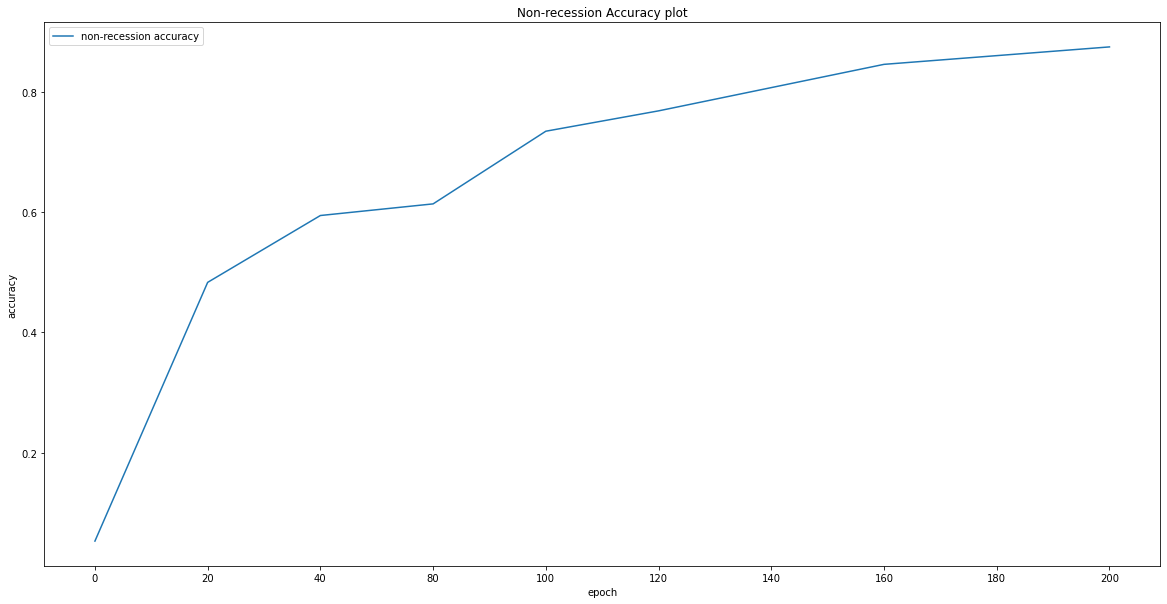

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

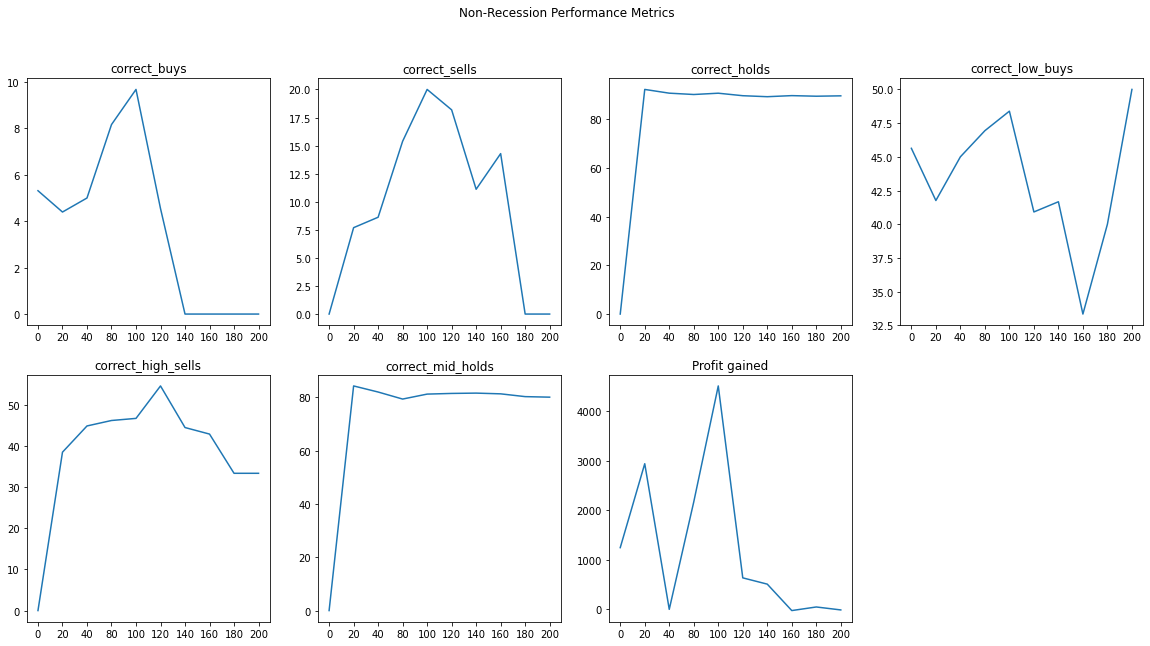

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

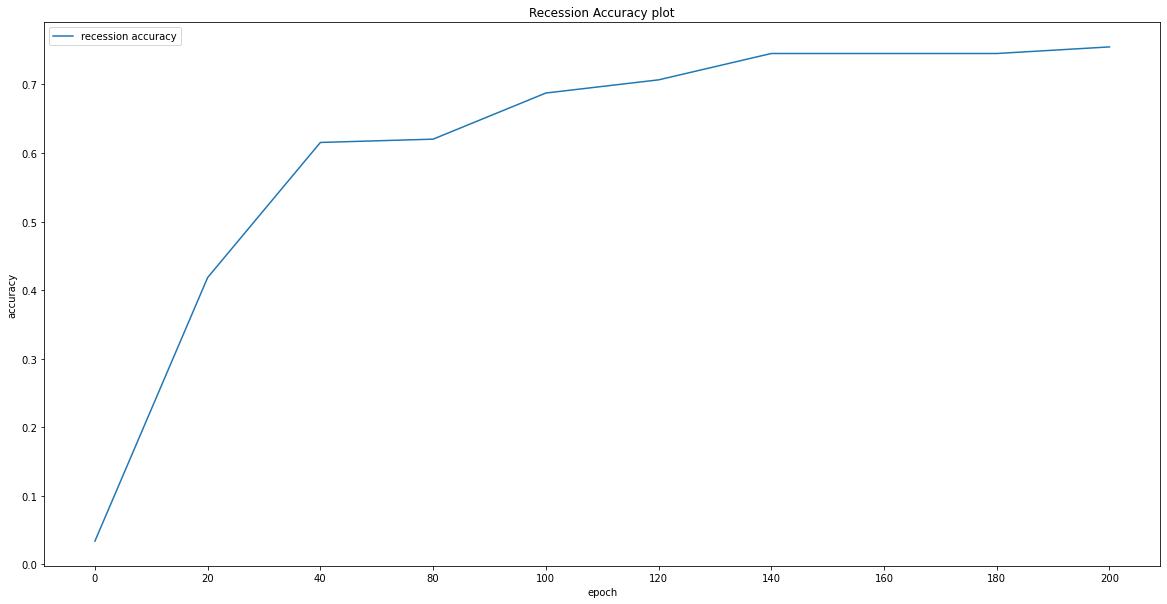

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

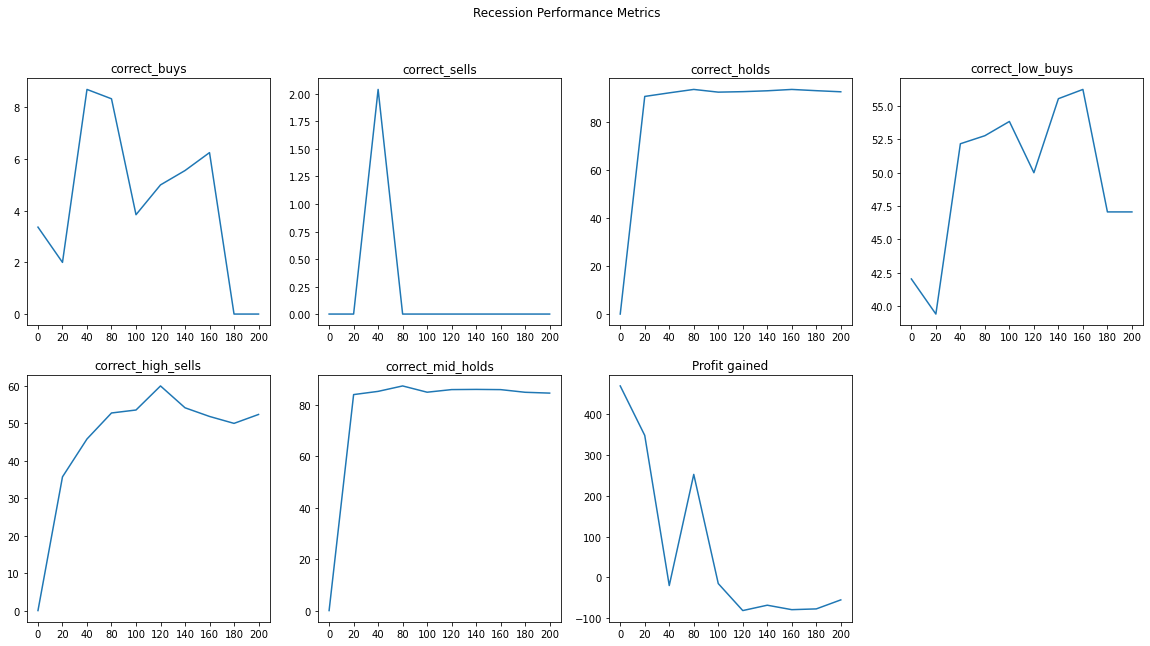

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Walmart

In [35]:
nr_test_sets = ['WMT']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-06    95.809998  97.317381 -74.593506  126209000.0     2.0
2018-12-07    94.769997  96.925476 -82.783532  115841800.0     2.0
2018-12-10    93.190002  96.350788 -89.635777  107345300.0     2.0
2018-12-11    93.940002  95.979897 -77.930950  114622200.0     2.0
2018-12-12    93.849998  95.652221 -79.172384  108169700.0     2.0


In [36]:
r_test_sets = ['WMT']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
     
        
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-12-06   118.660004  119.033405 -65.362993  215298600.0     2.0
2019-12-09   119.779999  119.148266 -31.594276  219639400.0     2.0
2019-12-10   119.360001  119.180840 -36.601335  214823400.0     2.0
2019-12-11   119.139999  119.174557 -43.790905  210541100.0     2.0
2019-12-12   119.000000  119.147702 -45.138918  207034700.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


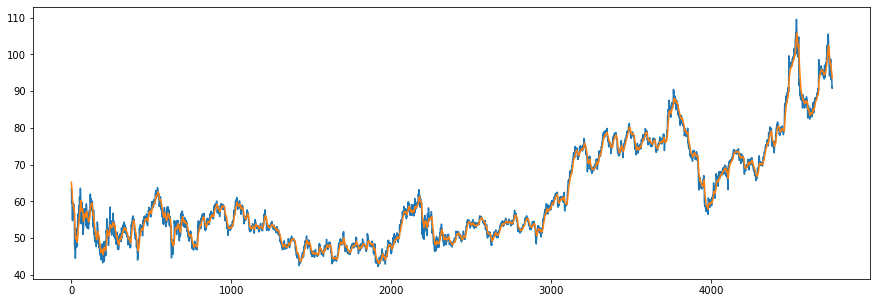

In [37]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/WMT_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

    
X  = np.array(sequential).reshape(-1, 25, 4)
y = labels
y = np.array(y)

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('WMT')]
    y = nr_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('WMT'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('WMT')]
    y = r_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('WMT'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.133709981167608, 1: 7.341085271317829, 2: 0.36716099641368616}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 37ms/step - loss: 0.2893 - accuracy: 0.5346 - mse: 0.4472 - weighted_accuracy: 0.3205 - weighted_mse: 0.5280 - val_loss: 0.2989 - val_accuracy: 0.0465 - val_mse: 0.3556 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.3556
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2119 - accuracy: 0.4237 - mse: 0.7633 - weighted_accuracy: 0.3993 - weighted_mse: 0.7807 - val_loss: 0.2897 - val_accuracy: 0.0454 - val_mse: 0.3851 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3851
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1935 - accuracy: 0.3152 - mse: 1.0189 - weighted_accuracy: 0.4424 - weighted_mse: 1.0087 - val_loss: 0.2797 - val_accuracy: 0.0454 - val_mse: 0.4218 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.4218
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 3ms/step - loss: 0.1903 - accuracy: 0.3516 - mse: 1.2372 - weighted_accuracy: 0.3516 - weighted_mse: 1.2372


<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.19031009078025818
Test accuracy: 0.35159817337989807


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 94
actual holds but predicted sell: 42
actual predicted holds: 65
Percentage buys correct: 5.9405940594059405%
Percentage sells correct: 12.244897959183673%
Percentage holds correct: 94.20289855072464%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.0%
Percentage high sells correct: 48.97959183673469%
Percentage mid holds correct: 88.40579710144928%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from previously bought: 35.36192191105296%
Share price: $0.3296552589924817
Shares owned at the moment: 0
Cash capital at the moment: $134.93713450866

Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1370 - accuracy: 0.3849 - mse: 1.6679 - weighted_accuracy: 0.7180 - weighted_mse: 1.5659 - val_loss: 0.1932 - val_accuracy: 0.3601 - val_mse: 1.6961 - val_weighted_accuracy: 0.3601 - val_weighted_mse: 1.6961
Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1354 - accuracy: 0.4351 - mse: 1.6551 - weighted_accuracy: 0.7149 - weighted_mse: 1.5844 - val_loss: 0.1979 - val_accuracy: 0.3358 - val_mse: 1.6824 - val_weighted_accuracy: 0.3358 - val_weighted_mse: 1.6824
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1356 - accuracy: 0.4240 - mse: 1.6622 - weighted_accuracy: 0.7216 - weighted_mse: 1.5824 - val_loss: 0.2095 - val_accuracy: 0.3316 - val_mse: 1.7537 - val_weighted_accuracy: 0.3316 - val_weighted_mse: 1.7537
Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1351 - accuracy: 0.4200 - mse: 1.6943 - weighted_accuracy: 0.7201 - weighted

<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 58
actual holds but predicted sell: 51
actual predicted holds: 92
Percentage buys correct: 7.936507936507937%
Percentage sells correct: 12.068965517241379%
Percentage holds correct: 93.87755102040816%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.064516129032256%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 87.75510204081633%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bought: 55.06714096943164%
Share price: $0.325962186747079
Shares owned at the moment: 0
Cash capital at the moment: $154.55786380487092


Share price: $0.12838321294937427
Shares owned at the moment: 12

30/30 [==============================] - 0s 8ms/step - loss: 0.1212 - accuracy: 0.5092 - mse: 1.9381 - weighted_accuracy: 0.7765 - weighted_mse: 1.8901 - val_loss: 0.1787 - val_accuracy: 0.4762 - val_mse: 1.9572 - val_weighted_accuracy: 0.4762 - val_weighted_mse: 1.9572
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1208 - accuracy: 0.4881 - mse: 1.9645 - weighted_accuracy: 0.7578 - weighted_mse: 1.9024 - val_loss: 0.1820 - val_accuracy: 0.4952 - val_mse: 2.0183 - val_weighted_accuracy: 0.4952 - val_weighted_mse: 2.0183
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1191 - accuracy: 0.5322 - mse: 1.9400 - weighted_accuracy: 0.7795 - weighted_mse: 1.9069 - val_loss: 0.1824 - val_accuracy: 0.4720 - val_mse: 1.9457 - val_weighted_accuracy: 0.4720 - val_weighted_mse: 1.9457
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1191 - accuracy: 0.5246 - mse: 1.9632 - weighted_accuracy: 0.7821 - weighted_mse: 1.9251

<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1158 - accuracy: 0.5496 - mse: 2.0163 - weighted_accuracy: 0.7948 - weighted_mse: 1.9861 - val_loss: 0.1843 - val_accuracy: 0.4710 - val_mse: 2.0966 - val_weighted_accuracy: 0.4710 - val_weighted_mse: 2.0966
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1148 - accuracy: 0.5465 - mse: 2.0387 - weighted_accuracy: 0.7939 - weighted_mse: 2.0113 - val_loss: 0.2106 - val_accuracy: 0.3875 - val_mse: 2.2159 - val_weighted_accuracy: 0.3875 - val_weighted_mse: 2.2159
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1138 - accuracy: 0.5380 - mse: 2.0834 - weighted_accuracy: 0.7961 - weighted_mse: 2.0570 - val_loss: 0.1897 - val_accuracy: 0.4667 - val_mse: 2.1742 - val_weighted_accuracy: 0.4667 - val_weighted_mse: 2.1742
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1132 - accuracy: 0.5451 - mse: 2.0997 - weighted_accuracy: 0.8042 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1371 - accuracy: 0.6758 - mse: 2.7670 - weighted_accuracy: 0.6758 - weighted_mse: 2.7670
Test loss: 0.13713014125823975
Test accuracy: 0.6757990717887878




<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 29
actual holds but predicted sell: 29
actual predicted holds: 143
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 9.375%
Percentage holds correct: 91.66666666666667%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 56.666666666666664%
Percentage high sells correct: 40.625%
Percentage mid holds correct: 85.8974358974359%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bought: 55.06714096943164%
Share price: $0.325962186747079
Shares owned at the moment: 0
Cash capital at the moment: $154.55786380487092


Share price: $0.3971563171524608
Shares owned at the moment: 388
Cash capit

30/30 [==============================] - 0s 10ms/step - loss: 0.0886 - accuracy: 0.6827 - mse: 2.9692 - weighted_accuracy: 0.8708 - weighted_mse: 3.0054 - val_loss: 0.1938 - val_accuracy: 0.5269 - val_mse: 3.1323 - val_weighted_accuracy: 0.5269 - val_weighted_mse: 3.1323
Epoch 18/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0891 - accuracy: 0.6843 - mse: 3.0520 - weighted_accuracy: 0.8714 - weighted_mse: 3.0463 - val_loss: 0.1940 - val_accuracy: 0.5660 - val_mse: 3.2947 - val_weighted_accuracy: 0.5660 - val_weighted_mse: 3.2947
Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0880 - accuracy: 0.7009 - mse: 3.0654 - weighted_accuracy: 0.8757 - weighted_mse: 3.0654 - val_loss: 0.1766 - val_accuracy: 0.5998 - val_mse: 3.2766 - val_weighted_accuracy: 0.5998 - val_weighted_mse: 3.2766
Epoch 20/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0884 - accuracy: 0.6940 - mse: 3.1402 - weighted_accuracy: 0.8606 - weighted_mse: 3.16

<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 23
actual holds but predicted sell: 34
actual predicted holds: 144
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 91.13924050632912%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 60.869565217391305%
Percentage high sells correct: 35.13513513513514%
Percentage mid holds correct: 86.07594936708861%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bought: 55.06714096943164%
Share price: $0.325962186747079
Shares owned at the moment: 0
Cash capital at the moment: $154.55786380487092


Share price: $0.3971563171524608
Shares owned at th

30/30 [==============================] - 0s 9ms/step - loss: 0.0764 - accuracy: 0.7505 - mse: 3.9486 - weighted_accuracy: 0.8939 - weighted_mse: 3.9497 - val_loss: 0.1742 - val_accuracy: 0.6579 - val_mse: 4.4252 - val_weighted_accuracy: 0.6579 - val_weighted_mse: 4.4252
Validation loss: 0.1741793006658554
Validation accuracy: 0.6578669548034668


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1431 - accuracy: 0.7339 - mse: 4.6462 - weighted_accuracy: 0.7339 - weighted_mse: 4.6462
Test loss: 0.14312703907489777
Test accuracy: 0.7339449524879456


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 12
actual holds but predicted sell: 32
actual predicted holds: 158
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 3.0303030303030303%
Percenta

<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0748 - accuracy: 0.7474 - mse: 3.8761 - weighted_accuracy: 0.9000 - weighted_mse: 3.8828 - val_loss: 0.1893 - val_accuracy: 0.6135 - val_mse: 4.1750 - val_weighted_accuracy: 0.6135 - val_weighted_mse: 4.1750
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0726 - accuracy: 0.7600 - mse: 3.9684 - weighted_accuracy: 0.9011 - weighted_mse: 3.9856 - val_loss: 0.2265 - val_accuracy: 0.5301 - val_mse: 4.1225 - val_weighted_accuracy: 0.5301 - val_weighted_mse: 4.1225
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0723 - accuracy: 0.7584 - mse: 4.0124 - weighted_accuracy: 0.9023 - weighted_mse: 4.0297 - val_loss: 0.1858 - val_accuracy: 0.6315 - val_mse: 4.0366 - val_weighted_accuracy: 0.6315 - val_weighted_mse: 4.0366
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0729 - accuracy: 0.7574 - mse: 4.0406 - weighted_accuracy: 0.9002 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1513 - accuracy: 0.7397 - mse: 6.8001 - weighted_accuracy: 0.7397 - weighted_mse: 6.8001
Test loss: 0.15127742290496826
Test accuracy: 0.7397260069847107


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 11
actual holds but predicted sell: 32
actual predicted holds: 158
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 8.571428571428571%
Percentage holds correct: 91.86046511627907%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 40.0%
Percentage mid holds correct: 85.96491228070175%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase 

<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu




RUNNING EPOCHS 140 - 160



Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0634 - accuracy: 0.7986 - mse: 4.8399 - weighted_accuracy: 0.9206 - weighted_mse: 4.7843 - val_loss: 0.1968 - val_accuracy: 0.6526 - val_mse: 5.2745 - val_weighted_accuracy: 0.6526 - val_weighted_mse: 5.2745
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0616 - accuracy: 0.7996 - mse: 4.9756 - weighted_accuracy: 0.9174 - weighted_mse: 4.9357 - val_loss: 0.2246 - val_accuracy: 0.5956 - val_mse: 5.2641 - val_weighted_accuracy: 0.5956 - val_weighted_mse: 5.2641
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0614 - accuracy: 0.8044 - mse: 4.9867 - weighted_accuracy: 0.9209 - weighted_mse: 4.9372 - val_loss: 0.1911 - val_accuracy: 0.6684 - val_mse: 5.1381 - val_weighted_accuracy: 0.6684 - val_weighted_mse: 5.1381
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0614 - accuracy: 0.7994 - mse: 4.9992 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.1710 - accuracy: 0.7626 - mse: 8.3383 - weighted_accuracy: 0.7626 - weighted_mse: 8.3383
Test loss: 0.17100359499454498
Test accuracy: 0.7625570893287659




<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 6
actual holds but predicted sell: 33
actual predicted holds: 162
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 10.81081081081081%
Percentage holds correct: 92.57142857142857%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 71.42857142857143%
Percentage high sells correct: 40.54054054054054%
Percentage mid holds correct: 86.7816091954023%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase from previously bought: 360.6124583679422%
Share price: $0.39018060098477814
Shares owned at the moment: 0
Cash capital at the moment: $459.1902522725085


Share price: $0.3971563171524608
Shares owned at t

7/7 [==============================] - 0s 3ms/step - loss: 0.1800 - accuracy: 0.7615 - mse: 7.9893 - weighted_accuracy: 0.7615 - weighted_mse: 7.9893
Test loss: 0.17997193336486816
Test accuracy: 0.7614678740501404


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 9
actual holds but predicted sell: 29
actual predicted holds: 164
Percentage buys correct: 10.0%
Percentage sells correct: 3.3333333333333335%
Percentage holds correct: 92.13483146067416%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 70.0%
Percentage high sells correct: 48.275862068965516%
Percentage mid holds correct: 84.8314606741573%


Capital: 100
Share price: $0.17307829619935666
Shares owned at the moment: 576
Cash capital at the moment: $0.03274536799078476


Price increase from previously 

<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 6
actual holds but predicted sell: 33
actual predicted holds: 162
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 10.81081081081081%
Percentage holds correct: 92.57142857142857%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 71.42857142857143%
Percentage high sells correct: 40.54054054054054%
Percentage mid holds correct: 86.7816091954023%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase from previously bought: 360.6124583679422%
Share price: $0.39018060098477814
Shares owned at the moment: 0
Cash capital at the moment: $459.1902522725085


Share price: $0.3971563171524608
Shares owned at t

7/7 [==============================] - 0s 3ms/step - loss: 0.1945 - accuracy: 0.7798 - mse: 9.5220 - weighted_accuracy: 0.7798 - weighted_mse: 9.5220
Test loss: 0.19453048706054688
Test accuracy: 0.7798165082931519


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 9
actual holds but predicted sell: 25
actual predicted holds: 168
Percentage buys correct: 10.0%
Percentage sells correct: 3.8461538461538463%
Percentage holds correct: 92.3076923076923%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 70.0%
Percentage high sells correct: 52.0%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.17307829619935666
Shares owned at the moment: 576
Cash capital at the moment: $0.03274536799078476


Price increase from previously bought: 54.403

<ipython-input-42-9e693caebe74>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-9e693caebe74>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-9e693caebe74>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

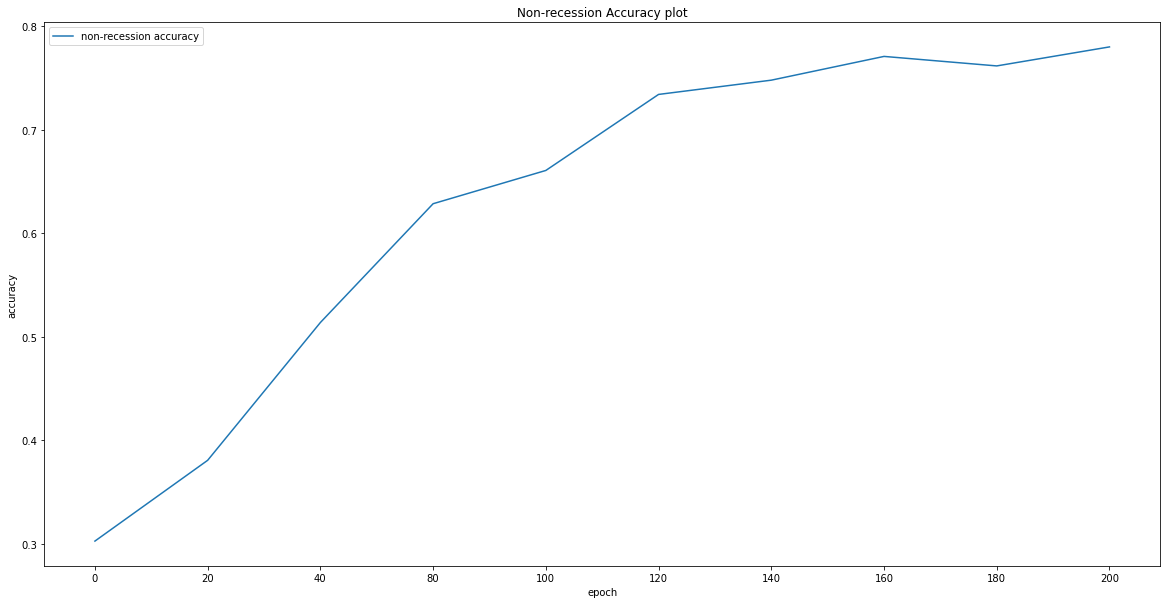

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

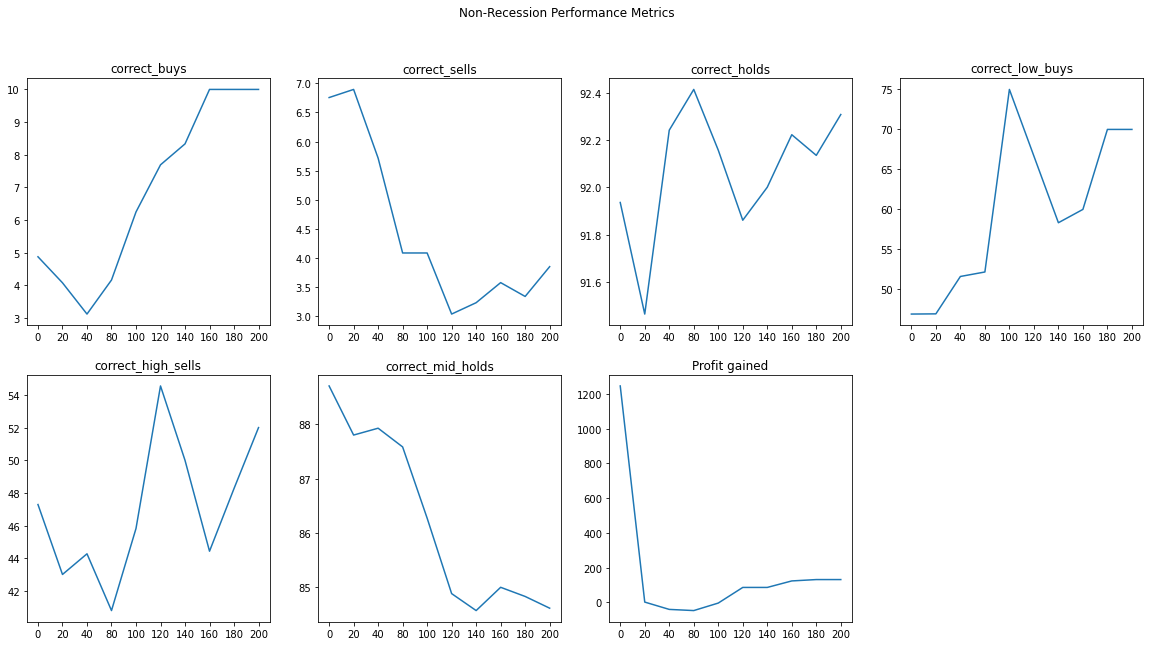

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

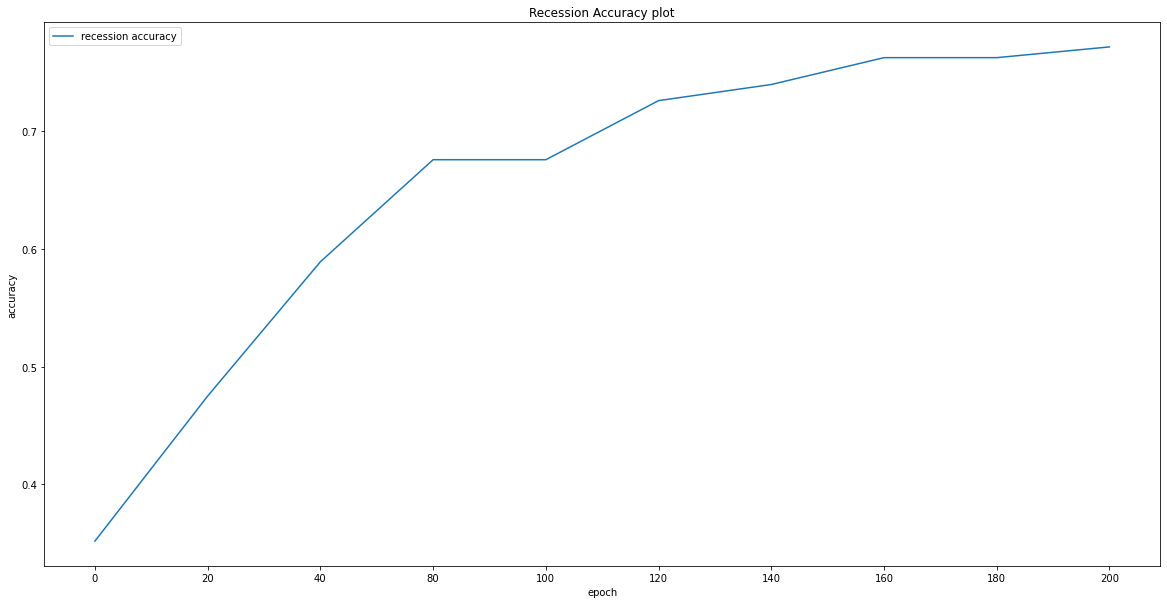

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

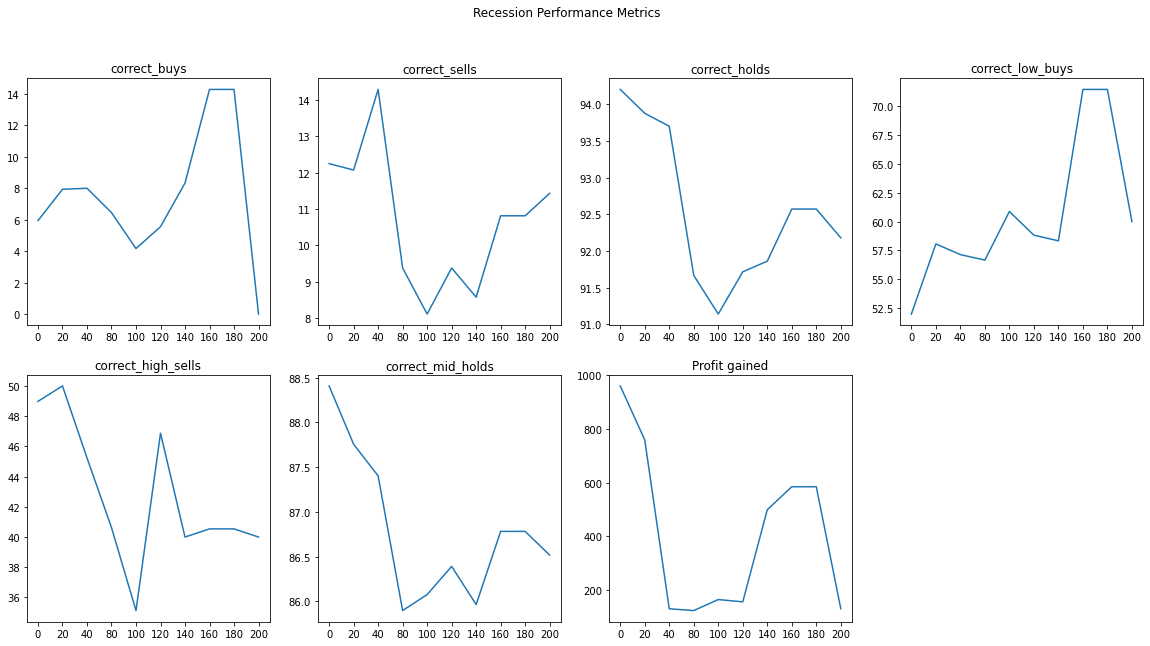

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Fresh Del Monte Produce Inc (small cap)

In [47]:
nr_test_sets = ['FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2018-12-06    31.690001  31.948964 -55.603431  41248900.0     2.0
2018-12-07    31.969999  31.952200 -49.568976  41460400.0     2.0
2018-12-10    32.189999  31.988784 -44.827613  41674600.0     2.0
2018-12-11    32.000000  31.990510 -48.922410  41408800.0     2.0
2018-12-12    32.380001  32.050432 -40.732734  41626100.0     2.0


In [48]:
r_test_sets = ['FDP']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-12-06    33.119999  32.380699  -4.000007 -5771300.0     2.0
2019-12-09    33.380001  32.534438 -13.261606 -5572400.0     2.0
2019-12-10    33.439999  32.673755 -11.111157 -5391600.0     2.0
2019-12-11    33.480000  32.797793 -10.954105 -5223300.0     2.0
2019-12-12    34.000000  32.982748  -1.298730 -5082700.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14     OBV_7  labels
Date                                                          
2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


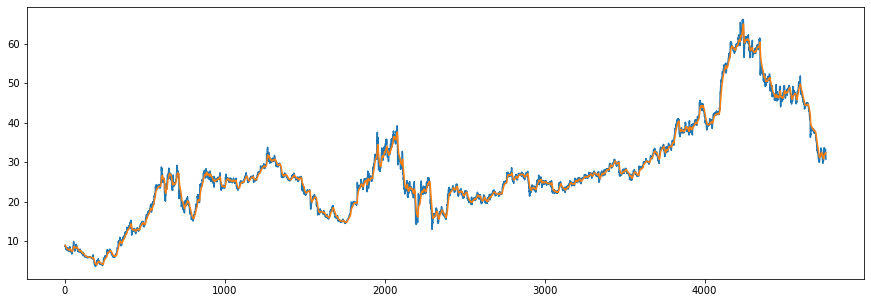

In [49]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/FDP_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 25, 4)
y = labels
y = np.array(y)

In [50]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [51]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [52]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('FDP')]
    y = nr_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('FDP'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('FDP')]
    y = r_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('FDP'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.298651252408478, 1: 7.215238095238095, 2: 0.3670542635658915}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 40ms/step - loss: 0.2902 - accuracy: 0.5399 - mse: 0.4509 - weighted_accuracy: 0.3123 - weighted_mse: 0.5382 - val_loss: 0.2988 - val_accuracy: 0.0444 - val_mse: 0.3557 - val_weighted_accuracy: 0.0444 - val_weighted_mse: 0.3557
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2156 - accuracy: 0.3897 - mse: 0.7579 - weighted_accuracy: 0.3824 - weighted_mse: 0.7810 - val_loss: 0.2894 - val_accuracy: 0.0465 - val_mse: 0.3836 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.3836
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.3491 - mse: 0.9810 - weighted_accuracy: 0.4481 - weighted_mse: 0.978 - 0s 8ms/step - loss: 0.1958 - accuracy: 0.3506 - mse: 0.9915 - weighted_accuracy: 0.4541 - weighted_mse: 0.9926 - val_loss: 0.2791 - val_accuracy: 0.0465 - val_mse: 0.4214 - val_we

7/7 [==============================] - 0s 3ms/step - loss: 0.1696 - accuracy: 0.5434 - mse: 1.1482 - weighted_accuracy: 0.5434 - weighted_mse: 1.1482


<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.16955414414405823
Test accuracy: 0.543379008769989


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 3
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 68
actual holds but predicted sell: 14
actual predicted holds: 117
Percentage buys correct: 2.73972602739726%
Percentage sells correct: 0.0%
Percentage holds correct: 88.63636363636364%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 47.22222222222222%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.3030303030303%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously bought: 61.57500335207209%
Share price: $0.9930083898145885
Shares owned at the moment: 0
Cash capital at the moment: $160.8629402978357


Share price: $0

7/7 [==============================] - 0s 3ms/step - loss: 0.1811 - accuracy: 0.5138 - mse: 1.6711 - weighted_accuracy: 0.5138 - weighted_mse: 1.6711
Test loss: 0.1811029613018036
Test accuracy: 0.5137614607810974


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 45
actual holds but predicted sell: 53
actual predicted holds: 100
Percentage buys correct: 13.461538461538462%
Percentage sells correct: 8.474576271186441%
Percentage holds correct: 93.45794392523365%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 48.07692307692308%
Percentage high sells correct: 50.847457627118644%
Percentage mid holds correct: 86.79245283018868%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Pri

<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1328 - accuracy: 0.5127 - mse: 1.6136 - weighted_accuracy: 0.7374 - weighted_mse: 1.5528 - val_loss: 0.1975 - val_accuracy: 0.4150 - val_mse: 1.7628 - val_weighted_accuracy: 0.4150 - val_weighted_mse: 1.7628
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1319 - accuracy: 0.5024 - mse: 1.6348 - weighted_accuracy: 0.7500 - weighted_mse: 1.5656 - val_loss: 0.1855 - val_accuracy: 0.4615 - val_mse: 1.5909 - val_weighted_accuracy: 0.4615 - val_weighted_mse: 1.5909
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1309 - accuracy: 0.4968 - mse: 1.6487 - weighted_accuracy: 0.7462 - weighted_mse: 1.5754 - val_loss: 0.1884 - val_accuracy: 0.4667 - val_mse: 1.7030 - val_weighted_accuracy: 0.4667 - val_weighted_mse: 1.7030
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1294 - accuracy: 0.4963 - mse: 1.6639 - weighted_accuracy: 0.7569 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1565 - accuracy: 0.6164 - mse: 1.9298 - weighted_accuracy: 0.6164 - weighted_mse: 1.9298
Test loss: 0.1565079391002655
Test accuracy: 0.6164383292198181


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 32
actual holds but predicted sell: 39
actual predicted holds: 128
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 91.42857142857143%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 48.83720930232558%
Percentage mid holds correct: 82.01438848920863%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price

<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1154 - accuracy: 0.5903 - mse: 1.8886 - weighted_accuracy: 0.7932 - weighted_mse: 1.8498 - val_loss: 0.2040 - val_accuracy: 0.4477 - val_mse: 2.1456 - val_weighted_accuracy: 0.4477 - val_weighted_mse: 2.1456
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1139 - accuracy: 0.5826 - mse: 1.9078 - weighted_accuracy: 0.8013 - weighted_mse: 1.8709 - val_loss: 0.1753 - val_accuracy: 0.5312 - val_mse: 1.9709 - val_weighted_accuracy: 0.5312 - val_weighted_mse: 1.9709
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1129 - accuracy: 0.5808 - mse: 1.9314 - weighted_accuracy: 0.8061 - weighted_mse: 1.8894 - val_loss: 0.1794 - val_accuracy: 0.5375 - val_mse: 2.0959 - val_weighted_accuracy: 0.5375 - val_weighted_mse: 2.0959
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1117 - accuracy: 0.5837 - mse: 1.9600 - weighted_accuracy: 0.8090 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1490 - accuracy: 0.6347 - mse: 2.5014 - weighted_accuracy: 0.6347 - weighted_mse: 2.5014
Test loss: 0.14902207255363464
Test accuracy: 0.6347032189369202


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 28
actual holds but predicted sell: 37
actual predicted holds: 134
Percentage buys correct: 9.375%
Percentage sells correct: 5.0%
Percentage holds correct: 91.15646258503402%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 59.375%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.1917808219178%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously bought: 0.237743381782573

<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 9ms/step - loss: 0.0979 - accuracy: 0.6737 - mse: 2.3136 - weighted_accuracy: 0.8511 - weighted_mse: 2.2985 - val_loss: 0.2062 - val_accuracy: 0.4984 - val_mse: 2.5688 - val_weighted_accuracy: 0.4984 - val_weighted_mse: 2.5688
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0969 - accuracy: 0.6626 - mse: 2.3447 - weighted_accuracy: 0.8488 - weighted_mse: 2.3299 - val_loss: 0.1626 - val_accuracy: 0.6431 - val_mse: 2.5008 - val_weighted_accuracy: 0.6431 - val_weighted_mse: 2.5008
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0957 - accuracy: 0.6576 - mse: 2.3647 - weighted_accuracy: 0.8525 - weighted_mse: 2.3416 - val_loss: 0.1712 - val_accuracy: 0.6008 - val_mse: 2.4922 - val_weighted_accuracy: 0.6008 - val_weighted_mse: 2.4922
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0946 - accuracy: 0.6676 - mse: 2.3735 - weighted_accuracy: 0.8598 - weighted_mse: 2.3614 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1335 - accuracy: 0.7397 - mse: 3.5460 - weighted_accuracy: 0.7397 - weighted_mse: 3.5460
Test loss: 0.13352830708026886
Test accuracy: 0.7397260069847107


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 25
actual holds but predicted sell: 16
actual predicted holds: 158
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 91.32947976878613%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 59.25925925925926%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 82.55813953488372%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Pric

<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0819 - accuracy: 0.7394 - mse: 2.8973 - weighted_accuracy: 0.8825 - weighted_mse: 2.8715 - val_loss: 0.2052 - val_accuracy: 0.5586 - val_mse: 3.0743 - val_weighted_accuracy: 0.5586 - val_weighted_mse: 3.0743
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0816 - accuracy: 0.7305 - mse: 2.9434 - weighted_accuracy: 0.8847 - weighted_mse: 2.9244 - val_loss: 0.1705 - val_accuracy: 0.6473 - val_mse: 3.1212 - val_weighted_accuracy: 0.6473 - val_weighted_mse: 3.1212
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0803 - accuracy: 0.7252 - mse: 2.9872 - weighted_accuracy: 0.8900 - weighted_mse: 2.9484 - val_loss: 0.1660 - val_accuracy: 0.6758 - val_mse: 3.2008 - val_weighted_accuracy: 0.6758 - val_weighted_mse: 3.2008
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0799 - accuracy: 0.7386 - mse: 3.0108 - weighted_accuracy: 0.8949 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1323 - accuracy: 0.8037 - mse: 4.7722 - weighted_accuracy: 0.8037 - weighted_mse: 4.7722
Test loss: 0.13226033747196198
Test accuracy: 0.8036529421806335




<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 17
actual holds but predicted sell: 9
actual predicted holds: 173
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 10.0%
Percentage holds correct: 91.05263157894737%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.01058201058201%


Capital: 100
Share price: $0.3970359089345914
Shares owned at the moment: 251
Cash capital at the moment: $0.06993282127545797


Price increase from previously bought: 129.34443778758958%
Share price: $0.9130838675370774
Shares owned at the moment: 0
Cash capital at the moment: $228.62372743351438


Share price: $0.49646952592956284
Shares owned at the moment: 459
Cash capi

7/7 [==============================] - 0s 3ms/step - loss: 0.1600 - accuracy: 0.7798 - mse: 5.9068 - weighted_accuracy: 0.7798 - weighted_mse: 5.9068
Test loss: 0.15998154878616333
Test accuracy: 0.7798165082931519


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 11
actual holds but predicted sell: 18
actual predicted holds: 169
Percentage buys correct: 0.0%
Percentage sells correct: 5.0%
Percentage holds correct: 90.37433155080214%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 65.0%
Percentage mid holds correct: 84.94623655913979%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase from previously bought: -27.04

<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0568 - accuracy: 0.8237 - mse: 4.6518 - weighted_accuracy: 0.9316 - weighted_mse: 4.4446 - val_loss: 0.2013 - val_accuracy: 0.6663 - val_mse: 4.7062 - val_weighted_accuracy: 0.6663 - val_weighted_mse: 4.7062
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0586 - accuracy: 0.8147 - mse: 4.6629 - weighted_accuracy: 0.9228 - weighted_mse: 4.4889 - val_loss: 0.1850 - val_accuracy: 0.7117 - val_mse: 5.1814 - val_weighted_accuracy: 0.7117 - val_weighted_mse: 5.1814
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0580 - accuracy: 0.8083 - mse: 4.7797 - weighted_accuracy: 0.9205 - weighted_mse: 4.5707 - val_loss: 0.1826 - val_accuracy: 0.7371 - val_mse: 5.4036 - val_weighted_accuracy: 0.7371 - val_weighted_mse: 5.4036
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0566 - accuracy: 0.8289 - mse: 4.8418 - weighted_accuracy: 0.9354 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.7808 - mse: 7.4488 - weighted_accuracy: 0.7808 - weighted_mse: 7.4488
Test loss: 0.1532147079706192
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 13
actual holds but predicted sell: 18
actual predicted holds: 168
Percentage buys correct: 13.333333333333334%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 90.8108108108108%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 60.0%
Percentage high sells correct: 57.89473684210526%
Percentage mid holds correct: 82.06521739130434%


Capital: 100
Share price: $0.3970359089345914
Shares owned at the moment: 251
Cash capital at the moment: $0.06993282127545797


Price increase fr

<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0484 - accuracy: 0.8619 - mse: 5.7862 - weighted_accuracy: 0.9493 - weighted_mse: 5.3862 - val_loss: 0.2042 - val_accuracy: 0.7138 - val_mse: 5.9758 - val_weighted_accuracy: 0.7138 - val_weighted_mse: 5.9758
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0493 - accuracy: 0.8456 - mse: 5.8178 - weighted_accuracy: 0.9378 - weighted_mse: 5.4549 - val_loss: 0.2039 - val_accuracy: 0.7223 - val_mse: 6.2139 - val_weighted_accuracy: 0.7223 - val_weighted_mse: 6.2139
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0495 - accuracy: 0.8408 - mse: 5.9561 - weighted_accuracy: 0.9324 - weighted_mse: 5.5629 - val_loss: 0.1959 - val_accuracy: 0.7645 - val_mse: 6.7031 - val_weighted_accuracy: 0.7645 - val_weighted_mse: 6.7031
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0478 - accuracy: 0.8564 - mse: 6.0075 - weighted_accuracy: 0.9436 - weighted_ms

<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 6
actual holds but predicted sell: 11
actual predicted holds: 182
Percentage buys correct: 25.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 91.4572864321608%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 75.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.82828282828282%


Capital: 100
Share price: $0.3970359089345914
Shares owned at the moment: 251
Cash capital at the moment: $0.06993282127545797


Price increase from previously bought: 129.34443778758958%
Share price: $0.9130838675370774
Shares owned at the moment: 0
Cash capital at the moment: $228.62372743351438


Share price: $0.49646952592956284
Shares owned at the moment: 459
Cash capital at the mome

7/7 [==============================] - 0s 3ms/step - loss: 0.2261 - accuracy: 0.8394 - mse: 10.7955 - weighted_accuracy: 0.8394 - weighted_mse: 10.7955
Test loss: 0.22607292234897614
Test accuracy: 0.8394495248794556


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 7
actual holds but predicted sell: 8
actual predicted holds: 183
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 90.14778325123153%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 71.42857142857143%
Percentage high sells correct: 62.5%
Percentage mid holds correct: 83.66336633663366%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase from previously bought: -30.

<ipython-input-54-e206617b0aeb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-e206617b0aeb>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-e206617b0aeb>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

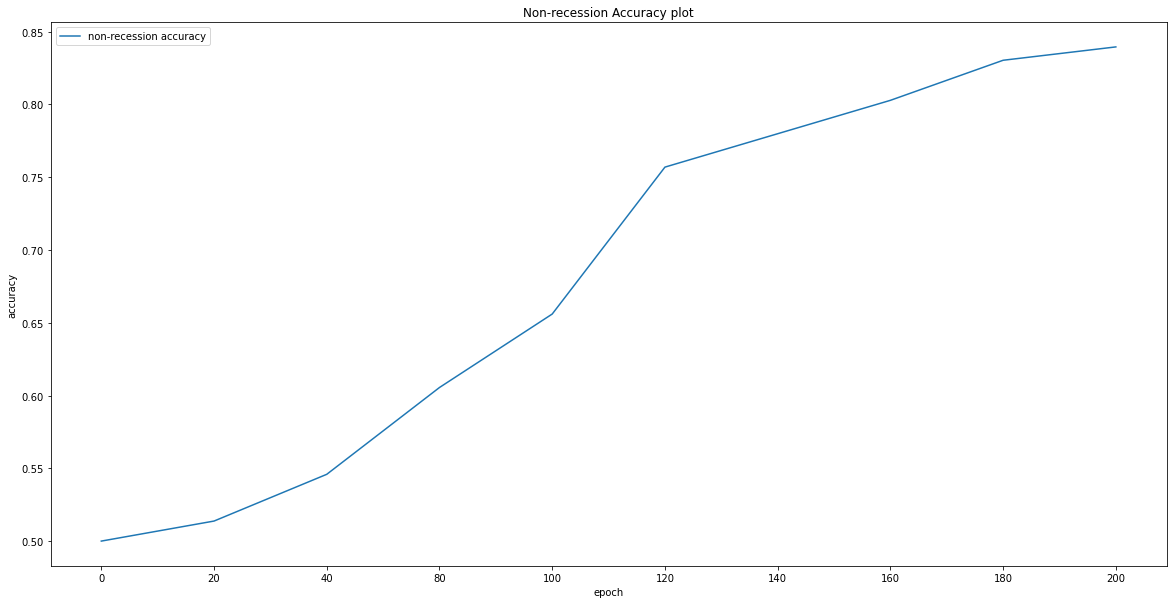

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

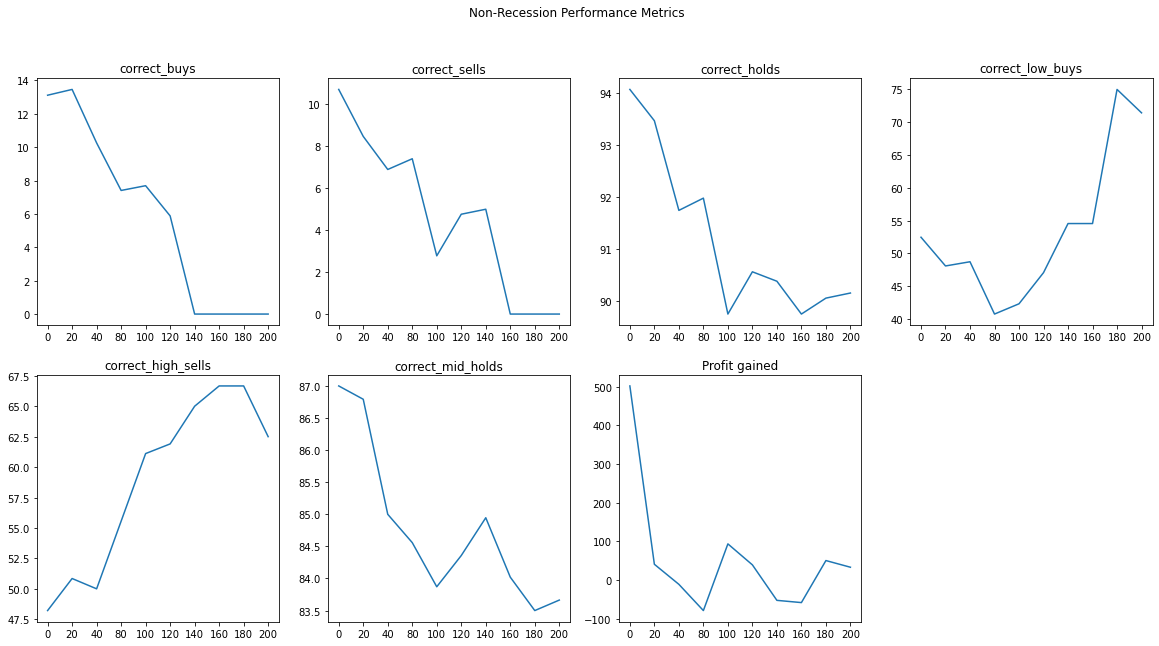

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

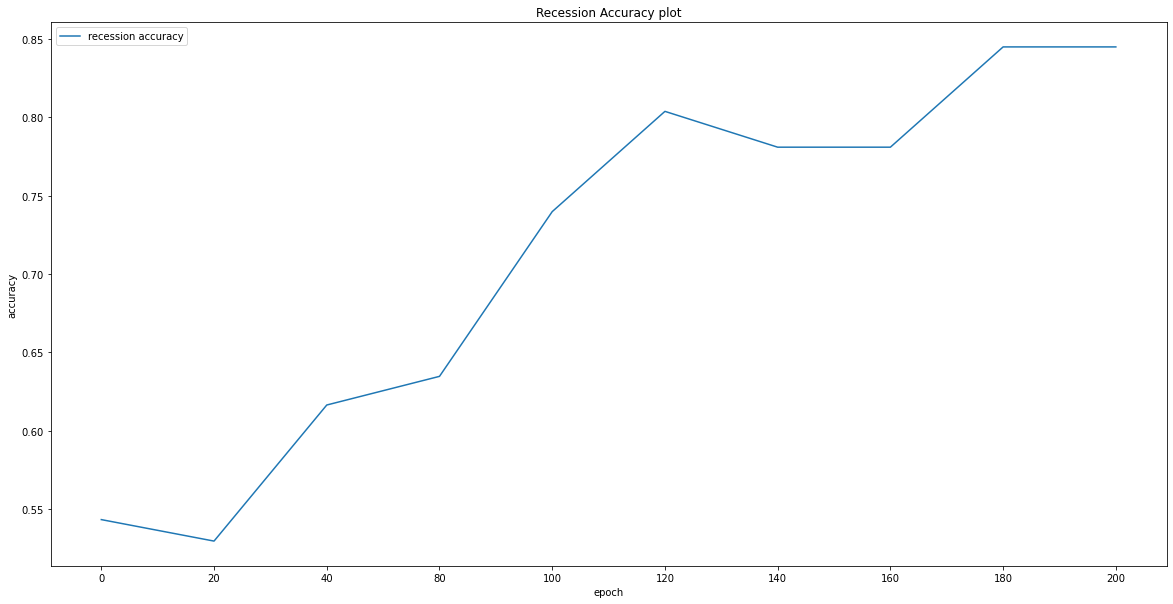

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

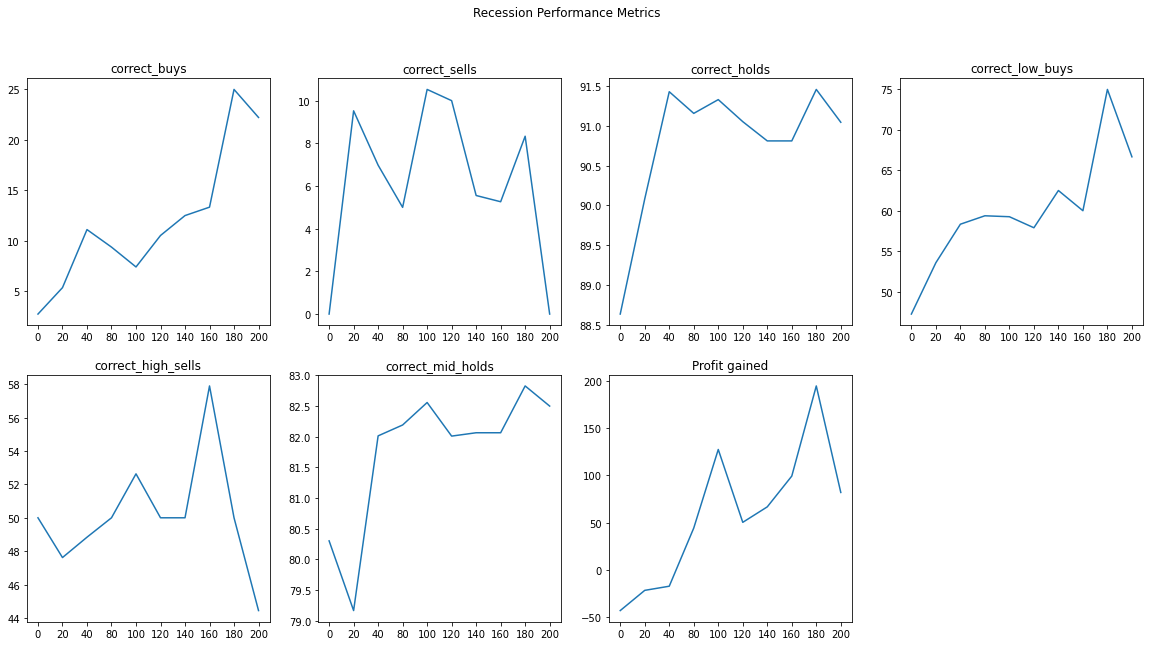

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")